In [91]:
import imageio
import imageio.v2 as imageio #lo agregué xq tiraba un warning que lo pedia...
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plti
from scipy.signal import convolve2d
import scipy.stats as st
from scipy.ndimage import zoom
from math import floor
%matplotlib inline

In [92]:
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

def yiq2rgb(img):
    return apply_matrix(img, M_RGB)
 
#Filtro Gaussiano
def gaussian(N, sigma=1):
    x = np.linspace(-sigma, sigma, N+1) #linspace crea un vector de valores entre -sigma y sigma igualmente distribuidos
    gaussian_dist = np.diff(st.norm.cdf(x)) #CDF = Cumulative distribution function NORM: distribucion normal/gaussiana.
    gaussian_filter = np.outer(gaussian_dist, gaussian_dist)
    return gaussian_filter/gaussian_filter.sum()

#--------------------------------------------------------------------------------------------------------------------------- 

#Downsample X2 cada 2 Px

def downsamplingx2 (img):
    ds = img[::2,::2]
    return ds

#--------------------------------------------------------------------------------------------------------------------------- 

#Downsample Promedio
#como yo se que ya le paso la imagen de la forma correcta, directamente hago la operacion

def ds_prom_x2(img):
    
    # tamaño matriz img 
    alto, ancho = len(img) , len(img[0])

    #basicamente aca la recorto a la img asi puedo asegurarme q tengo una matriz "par"
    if alto % 2 != 0:
        img = img[:-1, :]
    if ancho % 2 != 0:
        img = img[:, :-1]

    #nuevo tamaño de la matriz 
    nuevo_alto = alto // 2
    nuevo_ancho = ancho // 2

    #Creo una matriz donde voy a ir almacenando la info de la matriz downsampleada
    matriz_promediada = np.zeros((nuevo_alto, nuevo_ancho))

    # Recorro la matriz y calculo el promedio 
    #le puse esos nombres xq me voy moviendo con [a11 a12] osea un cuadrado de 2x2, por supuesto q no siempre es el mismo
    #                                            [a21 a22] pero es un nombre generico q le puse
    for i in range(nuevo_alto):
        for j in range(nuevo_ancho):
            a11 = img[2*i, 2*j]
            a12 = img[2*i, 2*j + 1]
            a21 = img[2*i + 1, 2*j]
            a22 = img[2*i + 1, 2*j + 1]
            promedio = (a11 + a12 + a21 + a22) / 4
            matriz_promediada[i, j] = promedio

    return matriz_promediada

#---------------------------------------------------------------------------------------------------------------------------  

#Filtro gaussiano + sampling cada 2 pixeles

def downsampling_gaussian(img):
    kernel = gaussian(6,2) 
    imgconfiltro = convolve2d(img, kernel, mode='full',boundary='symm')
    downsampleada = downsamplingx2(imgconfiltro)
    return downsampleada

#---------------------------------------------------------------------------------------------------------------------------

def upsamplingx2(img):
    
    #tomo el tamaño de la img
    
    height = img.shape[0] 
    width = img.shape[1]
    
    #genero una matriz nueva donde guardar todo
    
    resized_image=np.zeros(shape=(height*2, width*2))
    
    #voy rellenando la nueva matriz que tiene el doble de tamaño q la original con los pixeles de interés
    
    for i in range(0, height*2, 2):
        for j in range(0, width*2, 2):
            resized_image[i:i+2, j:j+2]=img[i//2,j//2]    
    return resized_image

#---------------------------------------------------------------------------------------------------------------------------

def ups_bilineal(img):
    
    #ya q en la teoria dice q funciona como "kernels" pues, estimo que esta manera de hacer la funcion es valida
    
    #tomo el tamaño de la img
    
    alto = img.shape[0] 
    ancho = img.shape[1]
    
    #hago variables q tengan el doble del ancho y alto para armar la nueva matriz
    alto2, ancho2 = alto * 2, ancho * 2

    #hago una imagen nueva de tamaño incrementado
    img_upsampleada = np.zeros((alto2, ancho2), dtype=img.dtype)
    img_upsampleada[::2, ::2] = img

    #defino un kernel de interpolacion bilineal
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]]) / 4

    # Aplico la convol
    img_upsampleada = convolve2d(img_upsampleada, kernel, mode='full',boundary='symm')

    return img_upsampleada

#---------------------------------------------------------------------------------------------------------------------------

def ups_bicubica(img):
    #intenté hacerla como la anterior, pero no hubo caso, y como no poseo mucho tiempo para entregarlo
    #decidí realizarlo con una librería, la idea como se puede ver en lo comentado abajo era similar a la bicubica
    #como en la teoria dice que se usan simil a los kernels, defino una matriz nueva del doble de tamaño q la original
    #para ir rellenandola y luego aplico el "kernel bicubico" y haría la operacion de convolucionar la img_gray con
    #el kernel para obtener el resultado, pero intenté cambiando el kernel e incluso hice un poco de reaserch en wikipedia
    #y en otros sitios para ver como es la funcion específicamente, pero con ninguno lo pude hacer funcionar
    #en sintesis, dejo el codigo en constancia del intento jaja
    #utilicé una función que está dentro de las librerias q estamos utilizando que hace esa operación según encontré..
    #para poder apreciar aunque sea el efecto y compararlo visualmente con la bilineal.
    """
    #ya q en la teoria dice q funciona como "kernels" pues, estimo que esta manera de hacer la funcion es valida
    
    #tomo el tamaño de la img
    
    alto = img.shape[0] 
    ancho = img.shape[1]
   
    alto, ancho = img.shape
    alto2, ancho2 = alto * 2, ancho * 2

    #hago una imagen nueva de tamaño incrementado
    img_upsampleada = np.zeros((alto2, ancho2), dtype=img.dtype)
    img_upsampleada[::2, ::2] = img
    #defino un kernel de interpolacion bicubica
    kernel = np.array([
    [ 0, -1,  2, -1],
    [-1,  5, -8,  4],
    [ 2, -8, 12, -6],
    [-1,  4, -6,  3]
    ]) / 6.0

    # Aplico la convol
    img_upsampleada = convolve2d(img_upsampleada, kernel, mode='same', boundary='symm')
    """
    upscaled_image = zoom(img, 2, order=3)
    return upscaled_image #img_upsampleada

#---------------------------------------------------------------------------------------------------------------------------

def upsampling_gaussian(img):
    kernel = gaussian(6,2) 
    imgconfiltro = convolve2d(img, kernel, mode='full',boundary='symm')
    upsampleada = upsamplingx2(imgconfiltro)
    return upsampleada

#---------------------------------------------------------------------------------------------------------------------------
def upsamplingConFFT(img):
    #agarro el ancho y el alto de la img 
    alto , ancho = img.shape
    #calculo la fft de laimg 
    img_fft = np.fft.fft2(img) #hago la fft
    img_fft = np.fft.fftshift(img_fft) #shifteo el cero como haciamos en el tp de convol
    #coloco un padding
    #si no mal entiendo de la pagina de numpy, estaría agregando filas y columnas arriba, abajo, a la izq y a la der
    #con lo cual agrego la mitad de ancho en la izq y en la der y la mitad de la altura arriba y abajo
    #lo cual seria si una img de 400x400 agrego 200 arriba y abajo y 200 der y izq tendría -> 800x800 que es lo q quiero..
    aux_img = np.pad(img_fft,((alto//2,alto//2),(ancho//2,ancho//2)),'constant')
    #tomo el nuevo alto y ancho
    nuevoalto, nuevoancho = aux_img.shape
    img_salida = np.zeros((nuevoalto,nuevoancho))
    img_salida = np.fft.ifft2(np.fft.ifftshift(aux_img)) #antitransformo 
    return img_salida.real
    
#---------------------------------------------------------------------------------------------------------------------------

def downsamplingConFFT(img):
    #agarro el ancho y el alto de la img 
    alto , ancho = img.shape
    #calculo la fft de laimg 
    img_fft = np.fft.fft2(img) #hago la fft
    img_fft = np.fft.fftshift(img_fft) #shifteo el cero como haciamos en el tp de convol
    #recorto 1/4 por cada lado, osea si tengo una img de 400x400 recorto 100 por todos los lados (arriba, abajo, izq, der)
    #con lo cual quedo con una img de 200x200 que sería lo logico para un downsampling x2
    aux_img = img_fft[alto//4:alto-alto//4, ancho//4:ancho-ancho//4]
    #tomo el nuevo alto y ancho
    nuevoalto, nuevoancho = aux_img.shape
    img_salida = np.zeros((nuevoalto,nuevoancho))
    img_salida = np.fft.ifft2(np.fft.ifftshift(aux_img)) #antitransformo 
    return img_salida.real
#---------------------------------------------------------------------------------------------------------------------------
def cuantizacion_uniforme(img,n):
    if((n>1) and (n<255)): #255 limite de la imagen
        n = n-1 #para que me coincida el número de niveles que quiero 
        aux = np.round(img*n)/n
    else:
        print("N debe ser mayor a 1 y menor a 255")
        aux =img
    return aux    
#---------------------------------------------------------------------------------------------------------------------------
def cuantizacion_dithering_scanline(img,n):
    F,C = img.shape
    aux = np.zeros((F,C))
    n = n-1
    for i in range(0,F):
        error = 0
        for j in range(1,C):
            pixel_original = img[i,j].copy()
            pixel_modificado = np.round(pixel_original*n+error)/n
            aux[i,j] = pixel_modificado
            error = error + pixel_original - pixel_modificado
    return aux

#la parte de bucle está inspirada en la teoría donde menciona lo siguiente
#   "error := 0; {asumimos esto para toda fila j}
#     for i:= 0 to scanline.widht-1 do 
#         begin
#         salida[i,j] := round( entrada[i,j] + error );
#         error:= error + salida[i,j] - entrada [i,j];
#         end;
#   "
#
#---------------------------------------------------------------------------------------------------------------------------
def cuantizacion_floyd_steinberg(img,n):
    height = img.shape[0] #dimension de la imagen
    width = img.shape[1]
    img_aux=np.array(img, dtype=float)    #Hago una imagen auxiliar para modificarla
    n = n-1
    for i in range(0, height-1): #voy hasta la anteultima fila
        for j in range(0, width-1): #voy hasta la anteultima columna
            pixel_anterior = img_aux[i,j].copy()
            pixel_siguiente = np.round(pixel_anterior*n)/n
            img_aux[i,j] = pixel_siguiente
            error = pixel_anterior - pixel_siguiente
            img_aux[i+1,j]   += error*(7/16)
            img_aux[i-1,j+1] += error*(3/16)
            img_aux[i,j+1]   += error*(5/16)
            img_aux[i+1,j+1] += error*(1/16)
    return img_aux
#---------------------------------------------------------------------------------------------------------------------------

(491, 612)


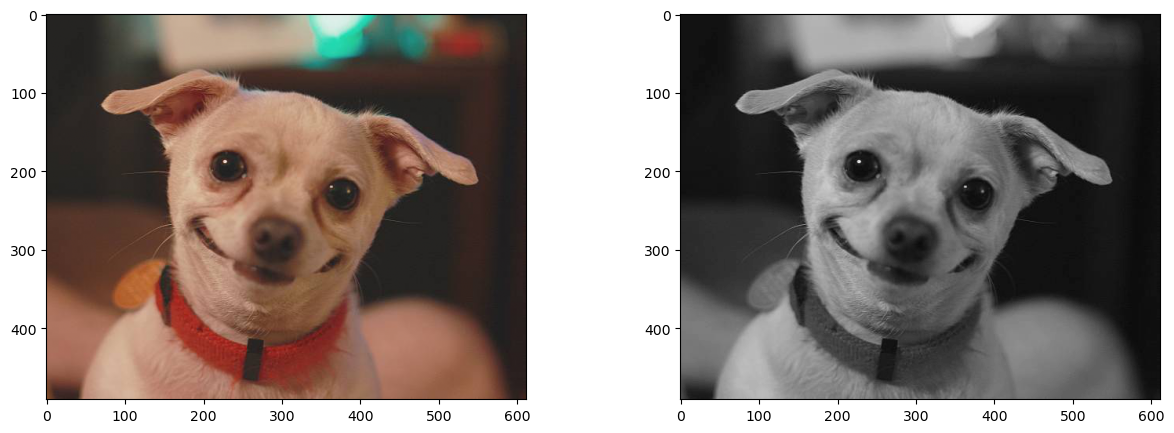

In [93]:
img_rgb  = imageio.imread("img/perritogracioso.jpg")/255  #Imagen RGB
img_gray = rgb2yiq(img_rgb)[:,:,0]               #Tomo el canal Y
print(img_gray.shape)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(img_gray, 'gray')

1. Upsampling / Downsampling x2

1.1. Definir una función que haga un downsampling x2 de la imagen de entrada utilizando los siguientes métodos:

Sampling cada 2 pixeles

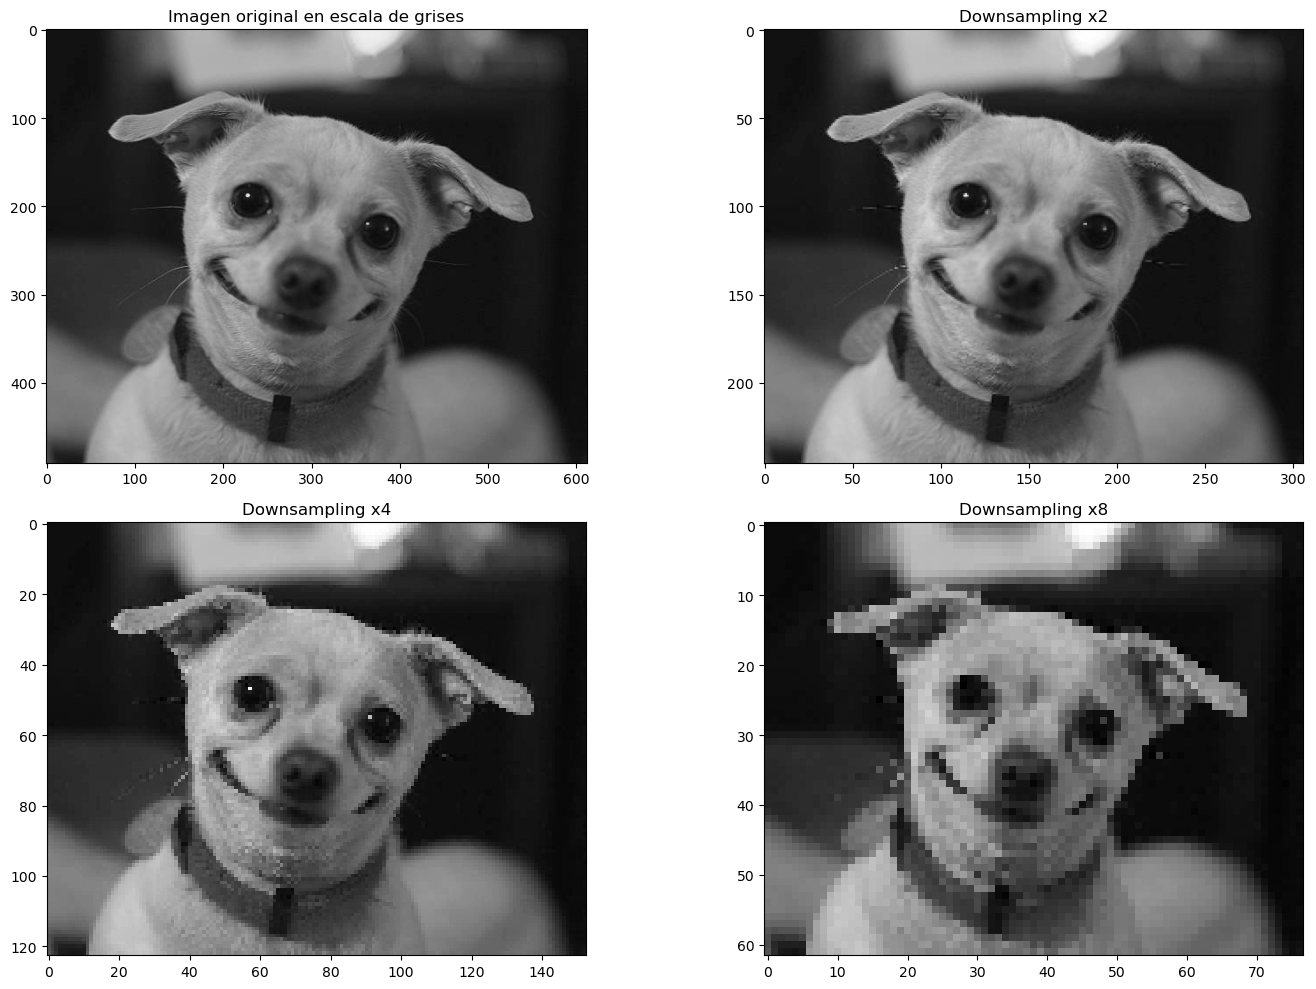

In [94]:
ds_x2 = downsamplingx2(img_gray)
ds_x4 = downsamplingx2(ds_x2) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.
ds_x8 =downsamplingx2(ds_x4) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.
#ploteo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title("Imagen original en escala de grises")
axes[0, 1].imshow(ds_x2, cmap='gray')
axes[0, 1].set_title("Downsampling x2")
axes[1, 0].imshow(ds_x4, cmap='gray')
axes[1, 0].set_title("Downsampling x4") 
axes[1, 1].imshow(ds_x8, cmap='gray')
axes[1, 1].set_title("Downsampling x8") 

# Ajustar los espacios entre subplots
plt.tight_layout()

#se puede apreciar que en el x2 el tamaño de la nueva imagen tiene la mitad de pixeles q la original
#y que en el x4 tiene 1/4 de pixeles q la original.

Promedio de una cuadrícula de 2x2

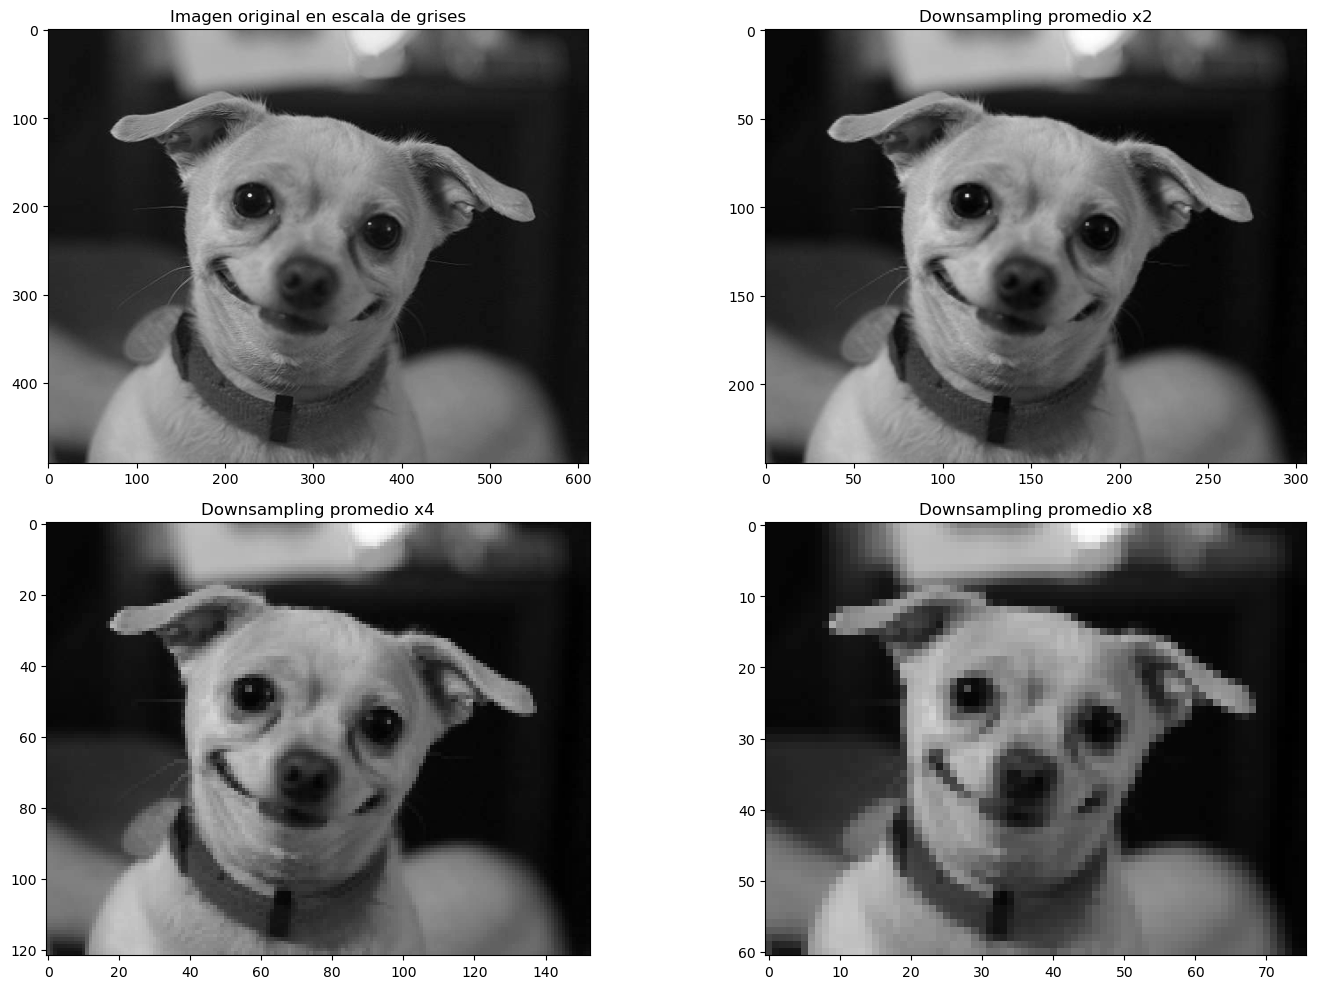

In [95]:
dsprom_x2 = ds_prom_x2(img_gray)
dsprom_x4 = ds_prom_x2(dsprom_x2) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.
dsprom_x8 = ds_prom_x2(dsprom_x4) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.

#ploteo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title("Imagen original en escala de grises")
axes[0, 1].imshow(dsprom_x2, cmap='gray')
axes[0, 1].set_title("Downsampling promedio x2")
axes[1, 0].imshow(dsprom_x4, cmap='gray')
axes[1, 0].set_title("Downsampling promedio x4") 
axes[1, 1].imshow(dsprom_x8, cmap='gray')
axes[1, 1].set_title("Downsampling promedio x8") 

# Ajustar los espacios entre subplots
plt.tight_layout()

Filtro gaussiano + sampling cada 2 pixeles

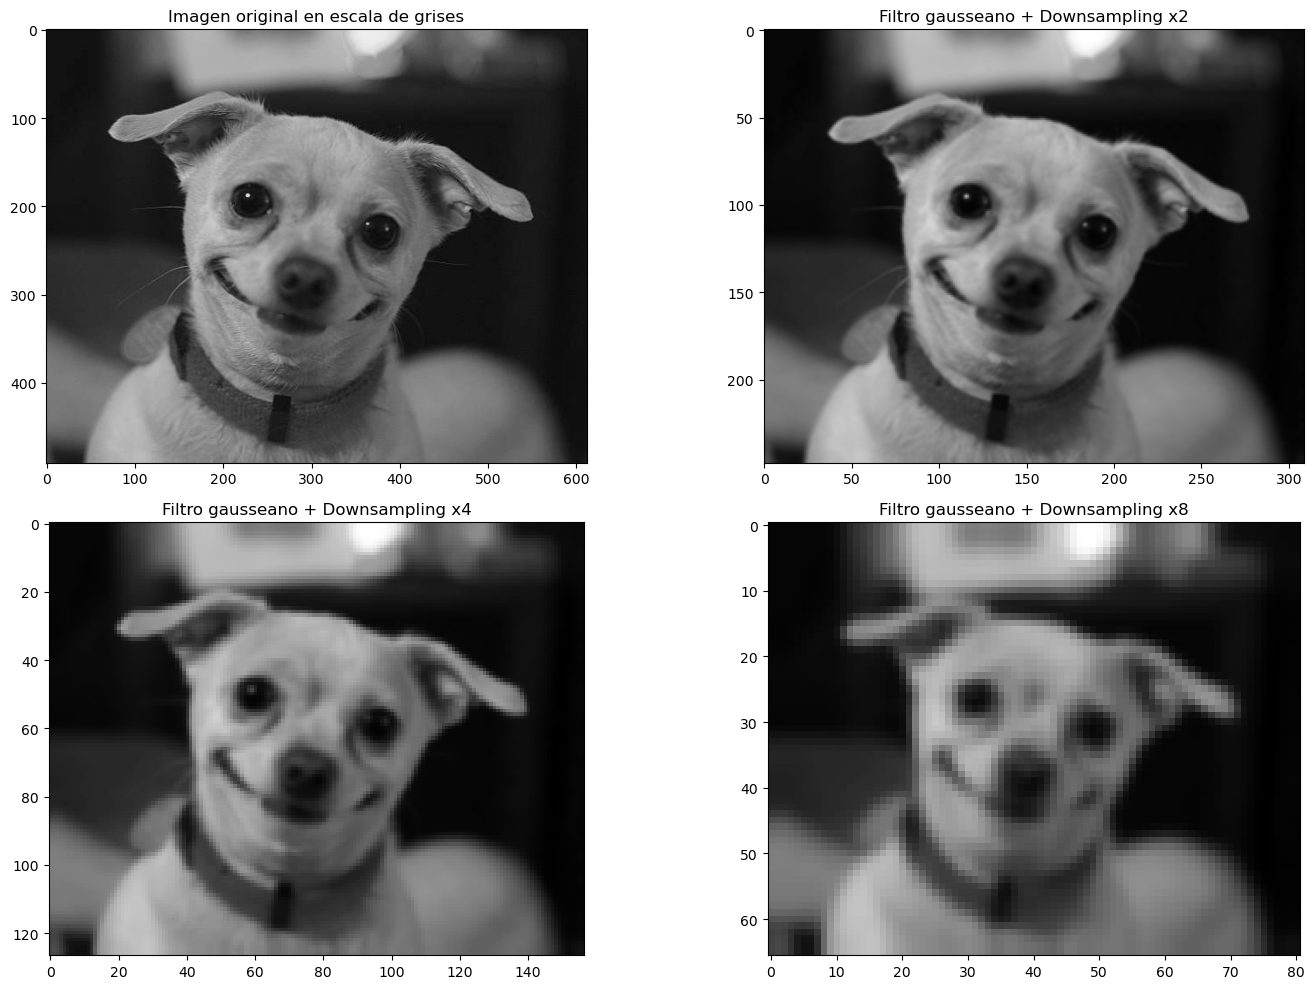

In [96]:
dsgauss_x2 = downsampling_gaussian(img_gray)
dsgauss_x4 = downsampling_gaussian(dsgauss_x2) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.
dsgauss_x8 = downsampling_gaussian(dsgauss_x4) #lo agregué para ver el efecto, aunque no lo pide el ejercicio.

#ploteo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title("Imagen original en escala de grises")
axes[0, 1].imshow(dsgauss_x2, cmap='gray')
axes[0, 1].set_title("Filtro gausseano + Downsampling x2")
axes[1, 0].imshow(dsgauss_x4, cmap='gray')
axes[1, 0].set_title("Filtro gausseano + Downsampling x4") 
axes[1, 1].imshow(dsgauss_x8, cmap='gray')
axes[1, 1].set_title("Filtro gausseano + Downsampling x8") 

# Ajustar los espacios entre subplots
plt.tight_layout()

1.2 Definir una función que haga un upsampling x2 de la imagen de entrada utilizando los siguientes métodos:

Repetir pixeles en una grilla de 2x2

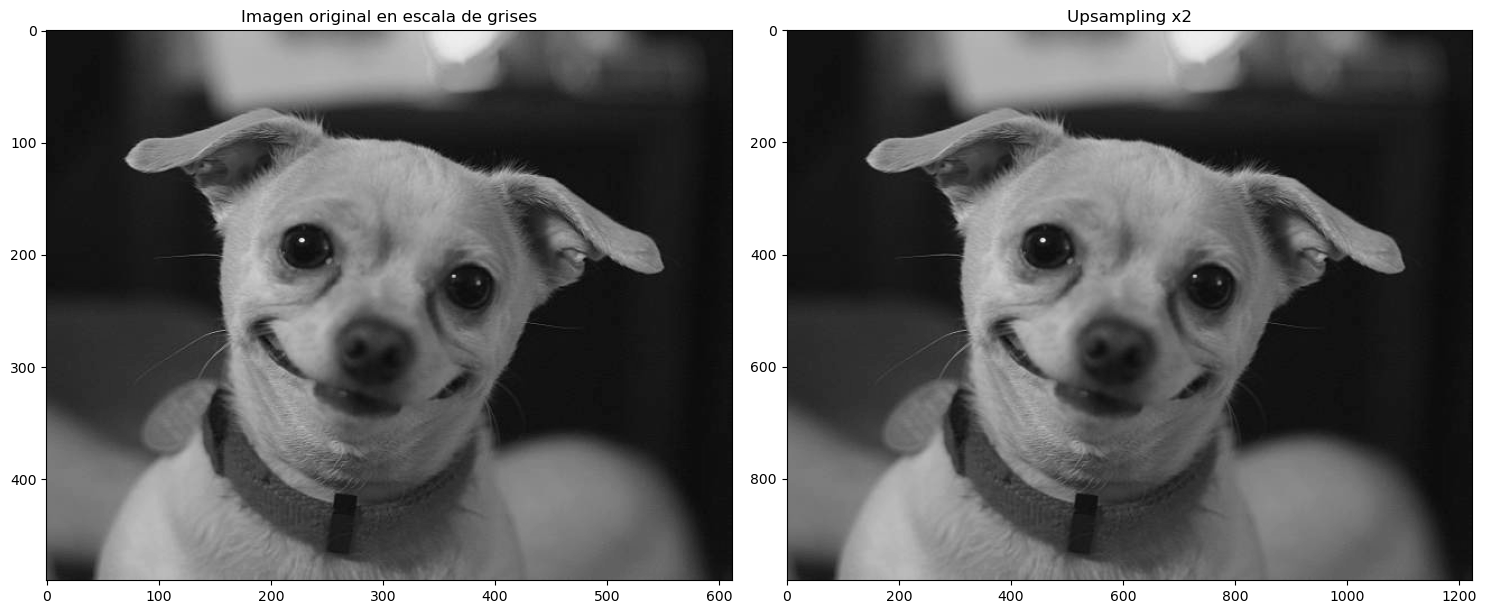

In [97]:
us_x2 =  upsamplingx2(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(us_x2, cmap='gray')
axes[1].set_title("Upsampling x2")

# Ajustar los espacios entre subplots
plt.tight_layout()

#se puede apreciar que en el upsampling x2 el tamaño de la nueva imagen tiene el doble de pixeles q la original

Interpolación bilineal

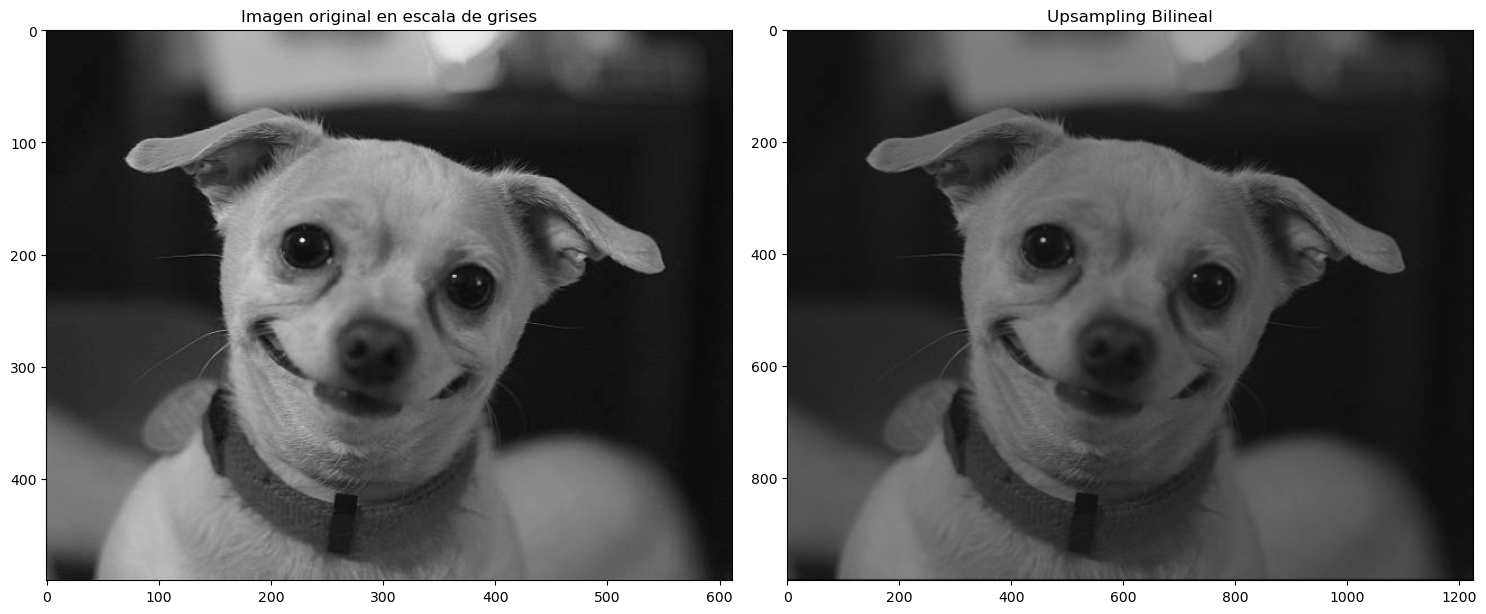

In [98]:
us_bi =  ups_bilineal(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(us_bi, cmap='gray')
axes[1].set_title("Upsampling Bilineal")

# Ajustar los espacios entre subplots
plt.tight_layout()

#se puede apreciar que en el upsampling x2 el tamaño de la nueva imagen tiene el doble de pixeles q la original

Interpolación bicúbica

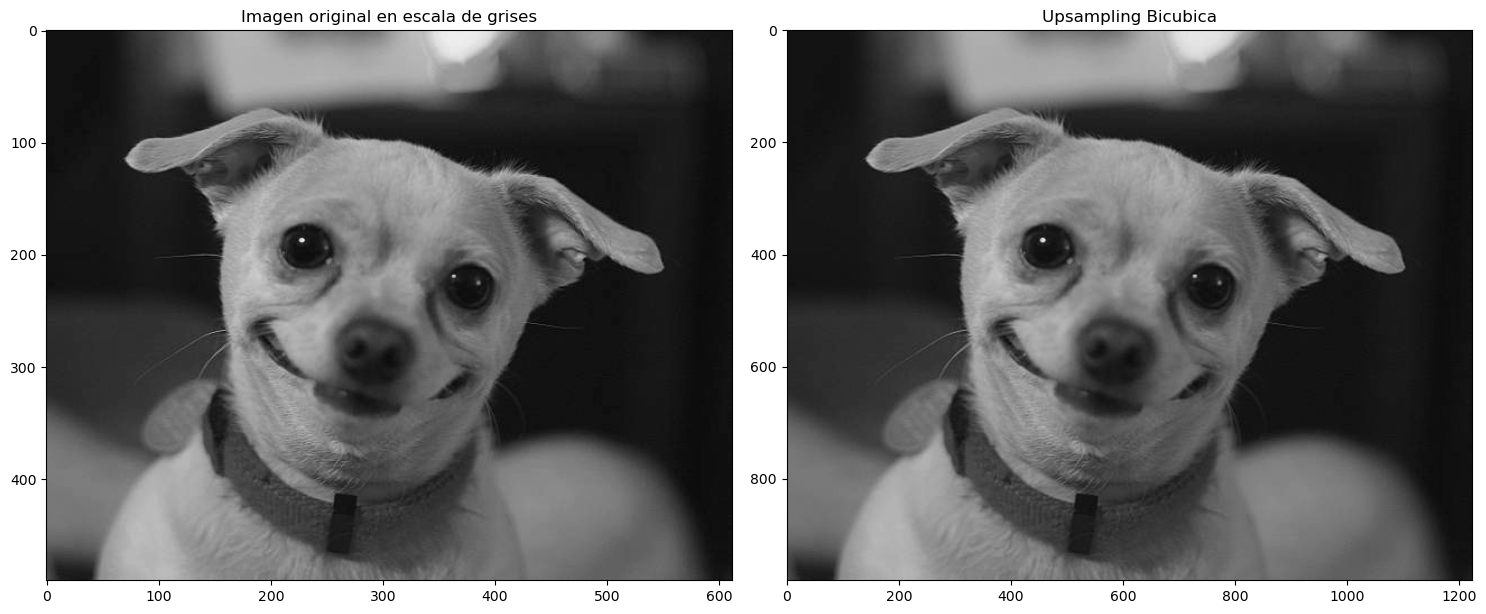

In [99]:
us_bic =  ups_bicubica(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(us_bic, cmap='gray')
axes[1].set_title("Upsampling Bicubica")

# Ajustar los espacios entre subplots
plt.tight_layout()

#se puede apreciar que en el upsampling x2 el tamaño de la nueva imagen tiene el doble de pixeles q la original

Repetir pixeles en una grilla de 2x2 y aplicar filtro gaussiano

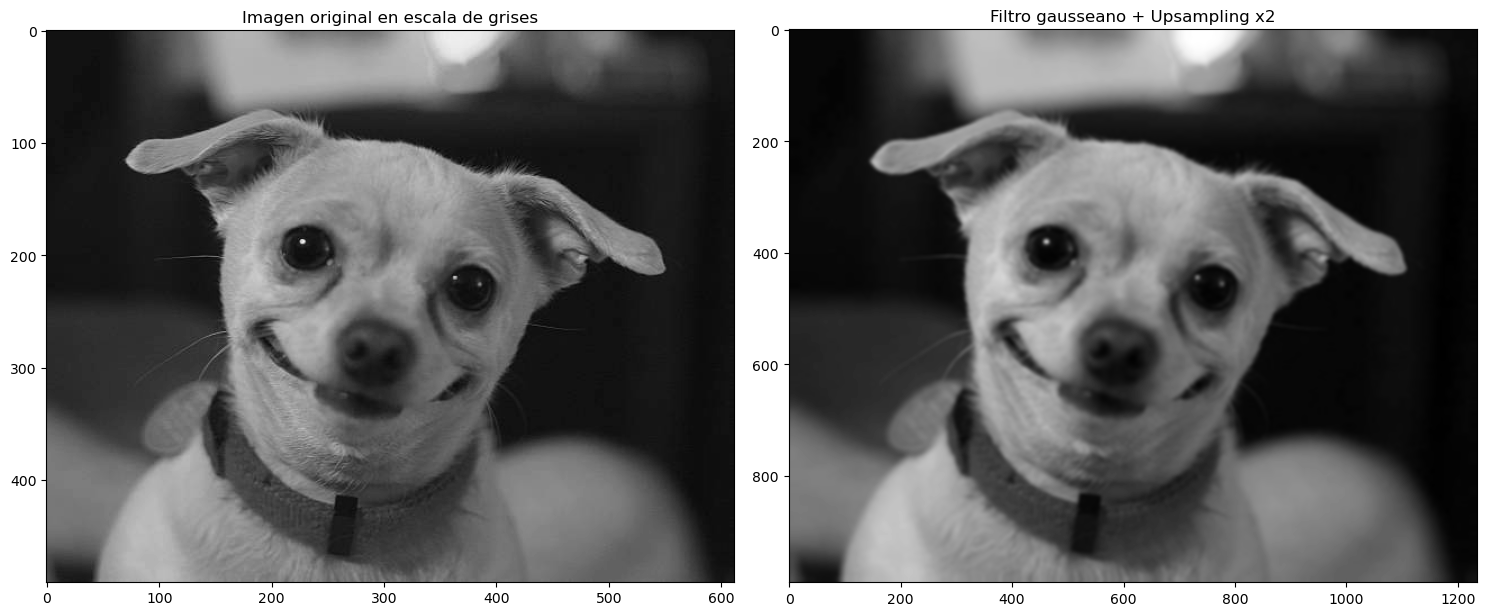

In [100]:
usgauss_x2 = upsampling_gaussian(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(usgauss_x2, cmap='gray')
axes[1].set_title("Filtro gausseano + Upsampling x2")


# Ajustar los espacios entre subplots
plt.tight_layout()

#se puede apreciar q si aumenta la resolucion de la imagen correctamente pero parece que como el upsampling x2 todavia es muy poco
#no se logra apreciar bien ya que el efecto en la imagen del filtro gausseano es mucho mayor.

2. Upsampling / Downsampling usando FFT

Upsampling

el tamaño de img orig es:  (491, 612)
el tamaño de img us con fft es:  (981, 1224)


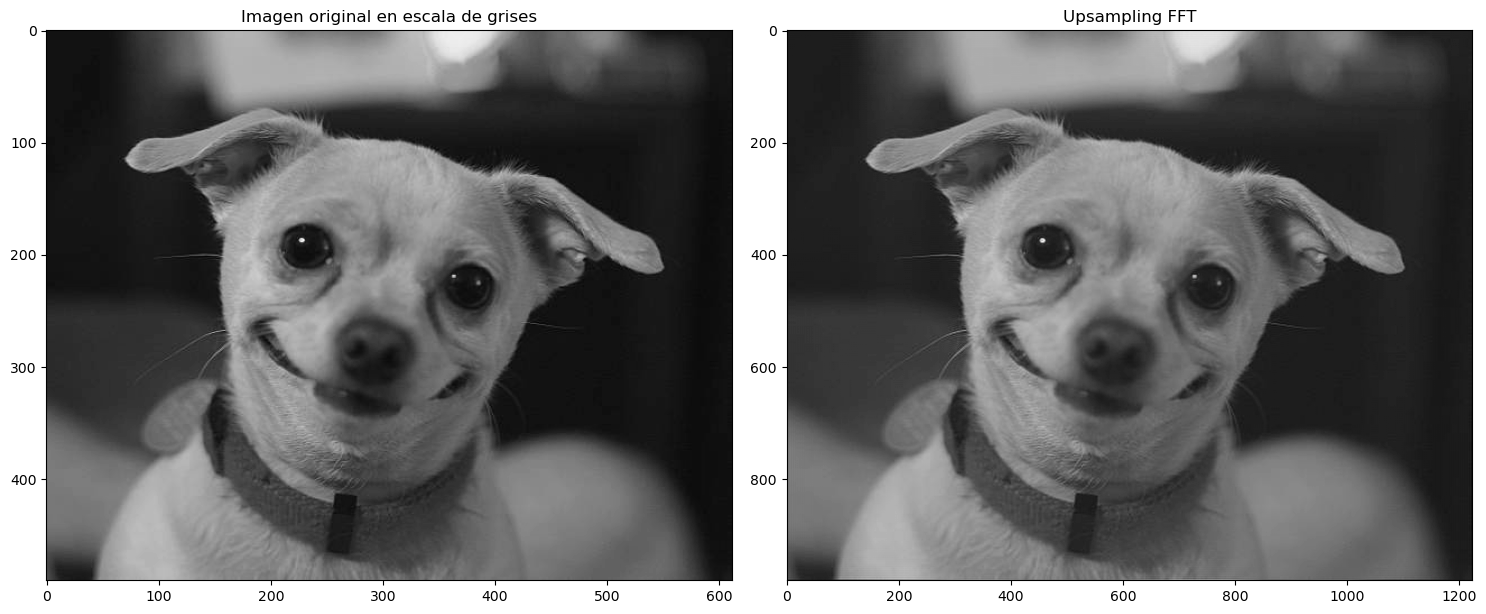

In [101]:
usfft = upsamplingConFFT(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(usfft, cmap='gray')
axes[1].set_title("Upsampling FFT")


# Ajustar los espacios entre subplots
plt.tight_layout()

#para ver si los tamaños estaban bien
print('el tamaño de img orig es: ',img_gray.shape)
print('el tamaño de img us con fft es: ',usfft.shape)

Downsampling

el tamaño de img orig es:  (491, 612)
el tamaño de img ds con fft es:  (247, 306)


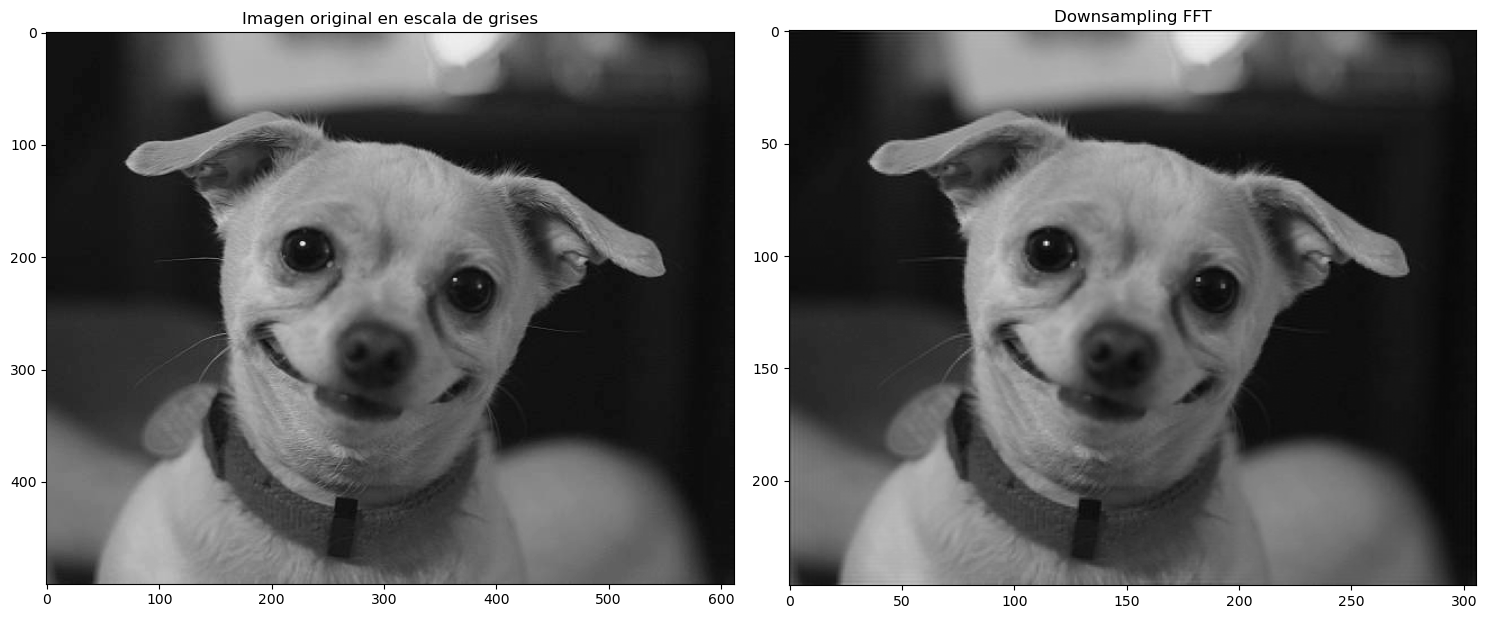

In [102]:
dsfft = downsamplingConFFT(img_gray)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(dsfft, cmap='gray')
axes[1].set_title("Downsampling FFT")


# Ajustar los espacios entre subplots
plt.tight_layout()

#para ver si los tamaños estaban bien
print('el tamaño de img orig es: ',img_gray.shape)
print('el tamaño de img ds con fft es: ',dsfft.shape)

3. Cuantización

Cuantización uniforme

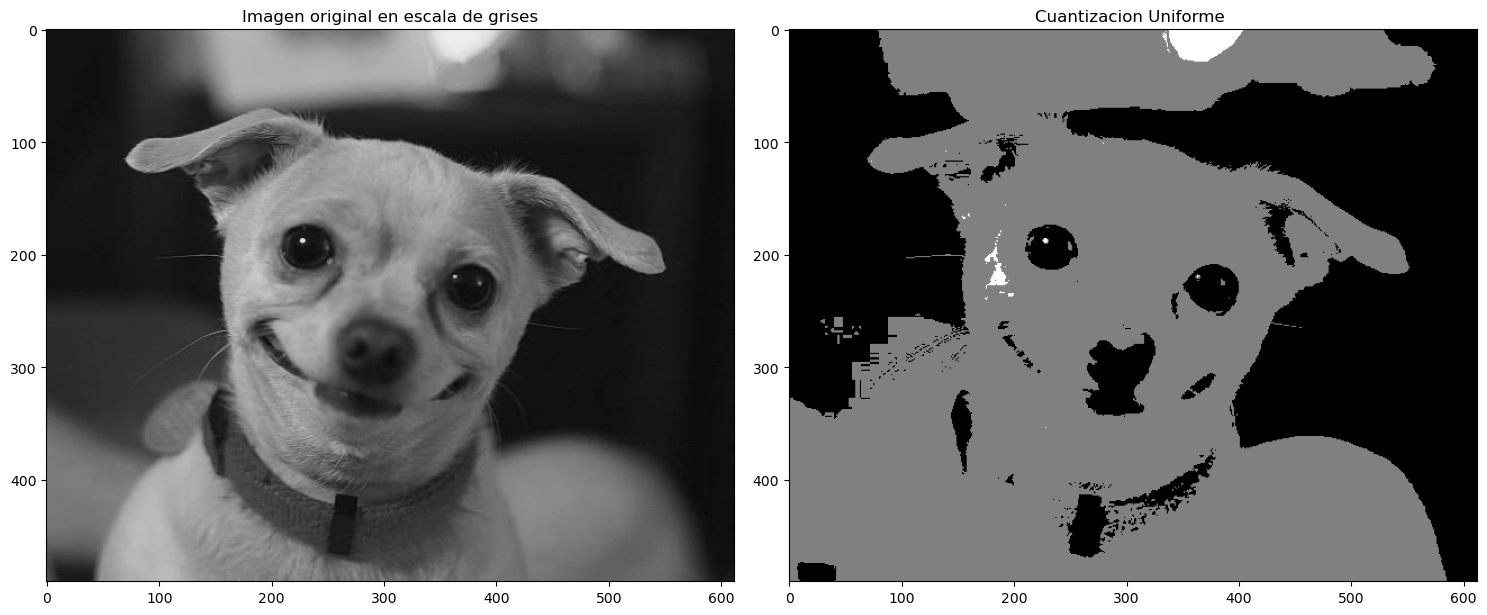

In [103]:
cuantiUnif = cuantizacion_uniforme(img_gray,3)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(cuantiUnif, cmap='gray')
axes[1].set_title("Cuantizacion Uniforme ")


# Ajustar los espacios entre subplots
plt.tight_layout()

Difusión del error por scanline

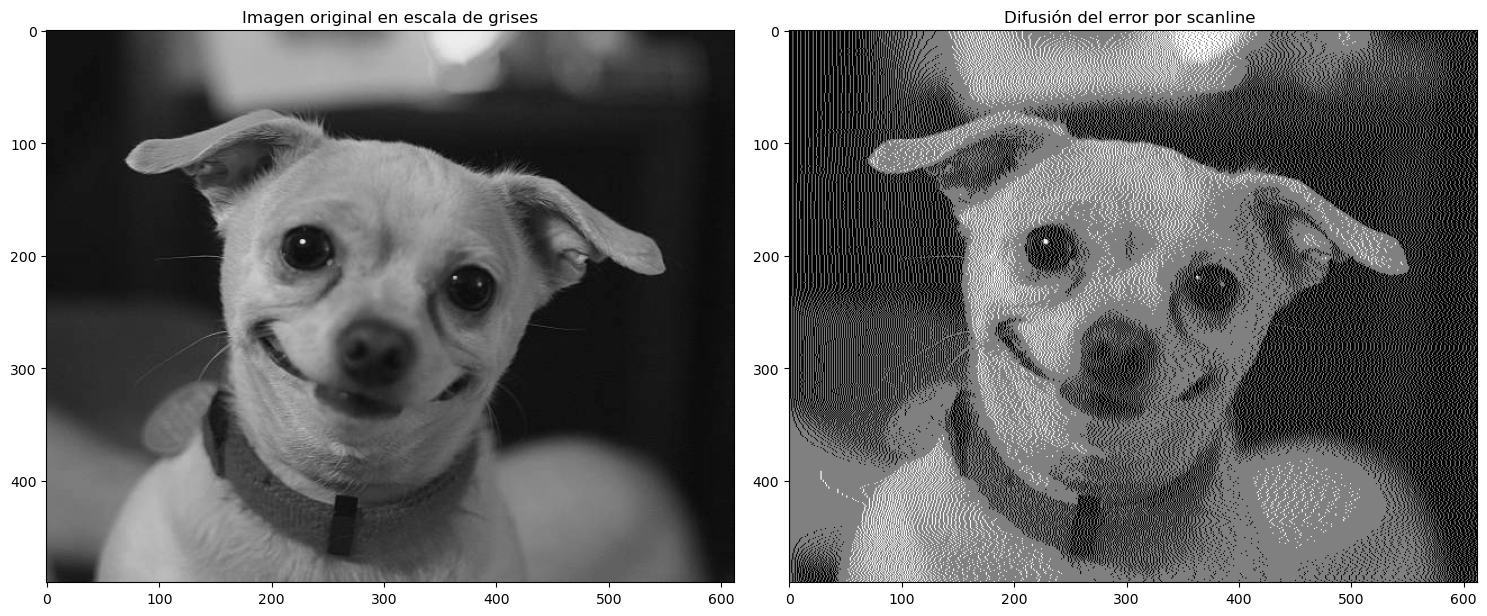

In [104]:
cuantiDithScan = cuantizacion_dithering_scanline(img_gray,3)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(cuantiDithScan, cmap='gray')
axes[1].set_title("Difusión del error por scanline ")


# Ajustar los espacios entre subplots
plt.tight_layout()

Dithering de Floyd-Steinberg

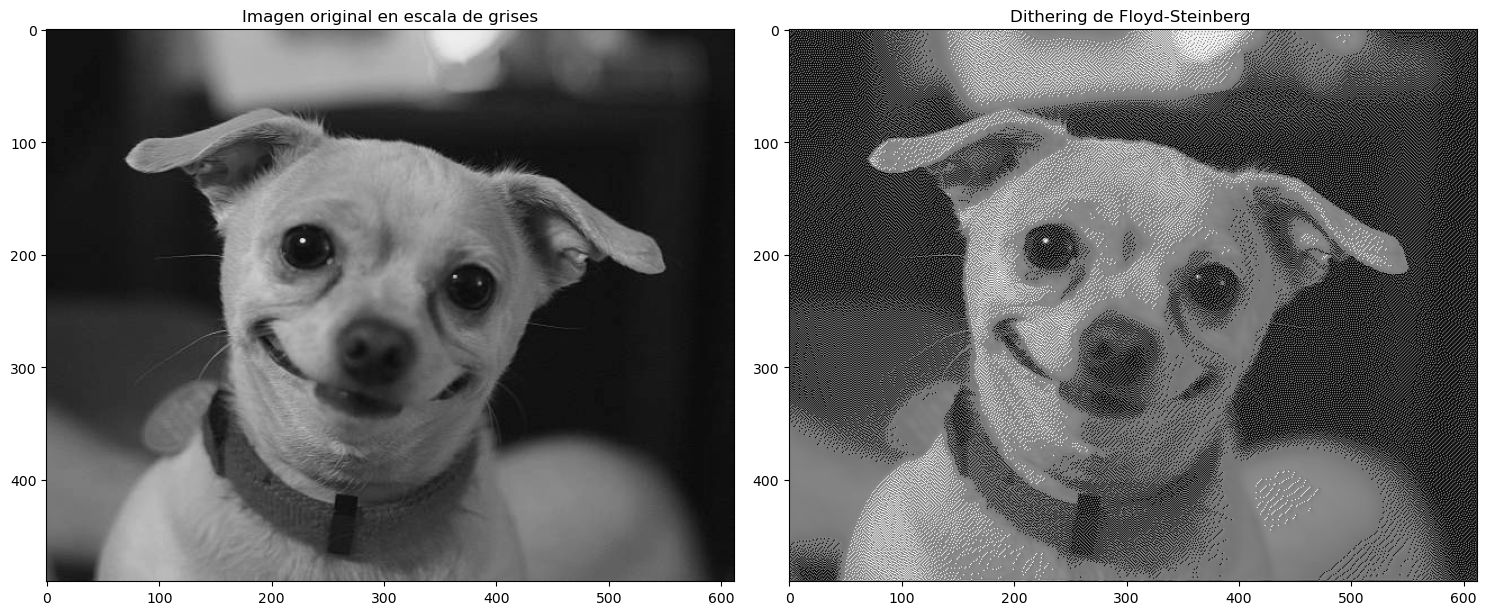

In [105]:
cuantiFS = cuantizacion_floyd_steinberg(img_gray,3)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Imagen original en escala de grises")
axes[1].imshow(cuantiFS, cmap='gray')
axes[1].set_title("Dithering de Floyd-Steinberg ")


# Ajustar los espacios entre subplots
plt.tight_layout()